# RL4CRN tutorial notebook: Habituation with recovery and speedup (CVODE)

Refer to the Logic Circuits tutorial for more information about the overall pipeline.


In [1]:
import os, sys, numpy as np

print("Python:", sys.version.split()[0])
print("CWD:", os.getcwd())


Python: 3.10.12
CWD: /local0/rossin/git/GenAI-Net/apps


## 1) Import RL4CRN helpers


In [2]:
from typing import Any, Callable, Dict, List, Sequence, Tuple, Union
import numpy as np
from itertools import product

from RL4CRN.utils.input_interface import (
    register_task_kind,
    overrides_get,
    Configurator,
    TaskKindBase,
    TaskSpec,
)

from RL4CRN.utils.default_tasks.HabituationTaskKind import HabituationGapTaskKind # <-- Gap searches for 2nd and 3rd habituation hallmarks

## 2) Build a template IO/CRN

Here we use the convenience builder `build_simple_IOCRN`, which provides an easy way to construct a I/O CRNs specifying dictionaries for input and output nodes.


In [3]:
from RL4CRN.utils.crn_builders import build_simple_IOCRN

# choose preset
cfg = Configurator.preset("paper")

# select simulator and set tolerances
cfg.solver.algorithm = "CVODE"
cfg.solver.rtol = 1e-6
cfg.solver.atol = 1e-6

# build template IO/CRN
species_labels = ['X_1', 'X_2', 'X_3']
crn, species_labels = build_simple_IOCRN(
    species=species_labels,
    production_input_map={"X_1": "u_1"},
    degradation_input_map={},
    dilution_map={"X_1": 0.1, "X_2": 0.1, "X_3": 0.1},  # add dilution to ensure steady state exists
    production_map={"X_2": 0.1},  # add basal production to X_2 nonzero peaks
    output_species="X_3",
    solver=cfg.solver,
)

print("Template CRN built.")
print(" - num_inputs:", crn.num_inputs)
print(" - num_species:", len(species_labels))
print(" - species:", species_labels)


Template CRN built.
 - num_inputs: 1
 - num_species: 3
 - species: ['X_1', 'X_2', 'X_3']


## 3) Build the reaction library (MAK)


In [4]:
from RL4CRN.utils.library_builders import build_MAK_library

# library components
library_components = build_MAK_library(crn, species_labels, order=2)

library, M, K, masks = library_components
print("Library built.")
print(" - M (num reactions in library):", M)
print(" - K (num parameters in library):", K)


Library built.
 - M (num reactions in library): 91
 - K (num parameters in library): 91


## 4) Define the task: RPA

- `kind="oscillator_mean"` selects the reward handler.
- `ic=("constant", 0.01)` sets initial concentrations.
- we use `u_values` to identify the combinations between input and disturbance
- we use `targets` to highlight the target output we seek to reach


In [5]:
HabituationGapTaskKind.pretty_help()

### TaskKind `habituation_gap`

**Required params**
- `pulse_shapes`: List[(t_on, t_off)] OR a single (t_on, t_off)
- `gap_time`: float OFF gap duration
- `n_repeats_pre`: int pulses before gap
- `n_repeats_post`: int pulses after gap
- `u_values`: List[float] grid for u

**Optional params**
- `freq_weight`: float frequency penalty weight (default 1.0)
- `gap_weight`: float gap penalty weight (default 5.0)
- `recovery_tol`: float recovery tolerance (default 0.05)
- `dishabituate_rho`: float dishabituation constraint (default 1.0)
- `ratio_weights`: float or list (default 1.0)
- `min_peak`: float (default 0.1)
- `max_peak`: float (default 2.0)
- `n_t`: int samples per simulation (default task.n_t)
- `sensitization`: bool (default False)

**Notes**
- If pulse_shapes has one entry, cross-frequency slope penalties are disabled. If multiple shapes
  are provided, a monotonicity penalty encourages faster habituation at higher frequency.


In [6]:
from RL4CRN.utils.input_interface import make_task, print_task_summary
import numpy as np

# Frequencies: 5s, 10s, 15s periods.
# Keep a fixed ON duration (e.g. 1s) and vary OFF so that (t_on + t_off) = period.
t_on = 1.0
periods = [5.0, 10.0, 15.0]                 # seconds
pulse_shapes = [(t_on, P - t_on) for P in periods]  # [(1,4), (1,9), (1,14)]

# IMPORTANT: Your multifreq loss sorts by period (smaller period = higher freq),
# so pass pulse_shapes in any order; it will be internally ordered.
# Still, it's good practice to provide them explicitly as above.

task = make_task(
    template_crn=crn,
    library_components=library_components,
    kind="habituation_gap",
    species_labels=species_labels,
    params={
        "pulse_shapes": pulse_shapes,   # <-- NEW (list of shapes)
        "n_repeats_pre": 10,
        "n_repeats_post": 10,
        "gap_time": 100.0,
        "n_t": 1000,
        "ic": "from_ss",
        "weights": "transient",
        "max_peak": 10.0,
        "min_peak": 0.1,
        "u_values": [1.0],
        "sensitization": True,

        # Multifreq-specific knobs (optional)
        "freq_weight": 1.0,        # weight of monotonic slope penalty across frequencies
        "gap_weight": 5.0,
        "recovery_tol": 0.05,
        "dishabituate_rho": 1.0,
        "ratio_weights": 1.0,      # or a list
    }
)

print_task_summary(task)

# --- Optional safety checks (recommended) ---
print("Sanity checks:")
print(" - template num_inputs:", crn.num_inputs)
print(" - first u shape:", np.asarray(task.u_list[0]).shape)
print(" - first u length:", len(task.u_list[0]))
assert len(task.u_list[0]) == crn.num_inputs, "Input dimension mismatch: u has wrong length!"

print("Pulse shapes used (t_on, t_off):", pulse_shapes)
print("Periods:", [a + b for a, b in pulse_shapes], " (smaller period = higher frequency)")


Task: habituation_gap
time_horizon: (1000,) [0..100.0]
num scenarios: 1
first 1 u: [array([1.], dtype=float32)]

Sanity checks:
 - template num_inputs: 1
 - first u shape: (1,)
 - first u length: 1
Pulse shapes used (t_on, t_off): [(1.0, 4.0), (1.0, 9.0), (1.0, 14.0)]
Periods: [5.0, 10.0, 15.0]  (smaller period = higher frequency)


## 5) Training configuration

We tune:
- `max_added_reactions`: episode length (how many reactions the agent can add)
- `epochs`: training iterations
- `render_every`: print progress cadence
- `seed`: reproducibility


In [7]:
# ---- Train config ----
cfg.train.max_added_reactions = 5
cfg.train.epochs = 11
cfg.train.render_every = 5
cfg.train.seed = 0

Rendering options

In [8]:
cfg.render.n_best = 100
cfg.render.disregarded_percentage = 0.9
cfg.render.mode = {  # Mode of the experiment
    'style': 'logger', 
    'task': 'sensitization_gap', 
    'format': 'image',
    'topology': True
}

## 6) Inspect full configuration (optional)

`cfg.describe()` prints a nested configuration dictionary.


In [9]:
cfg.describe()

{'task': None,
 'solver': {'algorithm': 'CVODE', 'rtol': 1e-06, 'atol': 1e-06},
 'train': {'epochs': 11,
           'max_added_reactions': 5,
           'render_every': 5,
           'hall_of_fame_size': 50,
           'batch_multiplier': 10,
           'seed': 0,
           'n_cpus': None,
           'batch_size': None},
 'policy': {'width': 1024,
            'depth': 5,
            'deep_layer_size': 10240,
            'continuous_distribution': {'type': 'lognormal_1D'},
            'entropy_weights_per_head': {'structure': 2.0, 'continuous': 1.0, 'discrete': 0.0, 'input_influence': 0.0},
            'ordering_enabled': False,
            'constraint_strength': inf},
 'agent': {'learning_rate': 0.0001,
           'entropy_scheduler': {'entropy_weight': 0.001,
                                 'topk_entropy_weight': 1.0,
                                 'remainder_entropy_weight': 1.0,
                                 'entropy_update_coefficient': 1,
                                 'e

## 7) Create session + trainer

This step wires together:
- parallel environments
- observer/tensorizer/actuator/stepper interfaces
- policy + agent
- the chosen task reward function

The returned object:
- `trainer`: runs rollout → reward eval → policy update loops


In [10]:
import os
from datetime import datetime
from pytorch_lightning.loggers import CometLogger

task_name = "Habituation_h3_Task"
timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

# Expect these in your environment:
#   COMET_API_KEY   (required)
#   COMET_WORKSPACE (required)
api_key = os.environ["COMET_API_KEY"]
workspace = os.environ["COMET_WORKSPACE"]

logger = CometLogger(
    api_key=api_key,
    project=task_name,
    workspace=workspace,
    name=f"{task_name}_{timestamp}",
)

logger = logger.experiment


COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/redsnic/habituation-h3-task/88fb5f62a58540c5a99aa54cef45280e



In [11]:
from RL4CRN.utils.input_interface import make_session_and_trainer
trainer = make_session_and_trainer(cfg, task, logger=logger)

## 8) Train and save checkpoints

We run for `cfg.train.epochs` epochs and periodically save a checkpoint.



[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails t

/local0/rossin/git/GenAI-Net/.venv/lib/python3.10/site-packages/RL4CRN/utils/default_tasks/HabituationTaskKind.py:209: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  x_ss = fsolve(lambda x: crn.rate_function(0.0, x, u), x_prev)
/local0/rossin/git/GenAI-Net/.venv/lib/python3.10/site-packages/RL4CRN/utils/default_tasks/HabituationTaskKind.py:209: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last five Jacobian evaluations.
  x_ss = fsolve(lambda x: crn.rate_function(0.0, x, u), x_prev)
/local0/rossin/git/GenAI-Net/.venv/lib/python3.10/site-packages/RL4CRN/utils/default_tasks/HabituationTaskKind.py:209: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  x_ss = fsolve(lambda x: crn.rate_function(0.0, x, u), x_prev)
/local0/rossin/git/GenAI-Net/.venv/lib/python3.10/site-packages/RL4CRN/uti



[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails 

/local0/rossin/git/GenAI-Net/.venv/lib/python3.10/site-packages/RL4CRN/utils/default_tasks/HabituationTaskKind.py:209: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  x_ss = fsolve(lambda x: crn.rate_function(0.0, x, u), x_prev)
/local0/rossin/git/GenAI-Net/.venv/lib/python3.10/site-packages/RL4CRN/utils/default_tasks/HabituationTaskKind.py:209: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  x_ss = fsolve(lambda x: crn.rate_function(0.0, x, u), x_prev)
/local0/rossin/git/GenAI-Net/.venv/lib/python3.10/site-packages/RL4CRN/utils/default_tasks/HabituationTaskKind.py:209: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  x_ss = fsolve(lambda x: crn.rate_function(0.0, x, u), x_prev)
/local0/rossin/git/GenAI-Net/.venv/lib/python3.10/site-packages/RL4CRN/utils/default_


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails t

/local0/rossin/git/GenAI-Net/.venv/lib/python3.10/site-packages/RL4CRN/utils/default_tasks/HabituationTaskKind.py:209: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  x_ss = fsolve(lambda x: crn.rate_function(0.0, x, u), x_prev)
/local0/rossin/git/GenAI-Net/.venv/lib/python3.10/site-packages/RL4CRN/utils/default_tasks/HabituationTaskKind.py:209: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last five Jacobian evaluations.
  x_ss = fsolve(lambda x: crn.rate_function(0.0, x, u), x_prev)
/local0/rossin/git/GenAI-Net/.venv/lib/python3.10/site-packages/RL4CRN/utils/default_tasks/HabituationTaskKind.py:209: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  x_ss = fsolve(lambda x: crn.rate_function(0.0, x, u), x_prev)
/local0/rossin/git/GenAI-Net/.venv/lib/python3.10/site-packages/RL4CRN/uti


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails t

/local0/rossin/git/GenAI-Net/.venv/lib/python3.10/site-packages/RL4CRN/utils/default_tasks/HabituationTaskKind.py:209: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last five Jacobian evaluations.
  x_ss = fsolve(lambda x: crn.rate_function(0.0, x, u), x_prev)
/local0/rossin/git/GenAI-Net/.venv/lib/python3.10/site-packages/RL4CRN/utils/default_tasks/HabituationTaskKind.py:209: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last five Jacobian evaluations.
  x_ss = fsolve(lambda x: crn.rate_function(0.0, x, u), x_prev)
/local0/rossin/git/GenAI-Net/.venv/lib/python3.10/site-packages/RL4CRN/utils/default_tasks/HabituationTaskKind.py:209: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last five Jacobian evaluations.
  x_ss = fsolve(lambda x: crn.rate_function(0.0, x, u), x_prev)
/local0/rossin/git/GenAI-Net/.venv/lib/python3.10/si


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails t

/local0/rossin/git/GenAI-Net/.venv/lib/python3.10/site-packages/RL4CRN/utils/default_tasks/HabituationTaskKind.py:209: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  x_ss = fsolve(lambda x: crn.rate_function(0.0, x, u), x_prev)
/local0/rossin/git/GenAI-Net/.venv/lib/python3.10/site-packages/RL4CRN/utils/default_tasks/HabituationTaskKind.py:209: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last five Jacobian evaluations.
  x_ss = fsolve(lambda x: crn.rate_function(0.0, x, u), x_prev)
/local0/rossin/git/GenAI-Net/.venv/lib/python3.10/site-packages/RL4CRN/utils/default_tasks/HabituationTaskKind.py:209: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  x_ss = fsolve(lambda x: crn.rate_function(0.0, x, u), x_prev)
/local0/rossin/git/GenAI-Net/.venv/lib/python3.10/site-packages/RL4CRN/uti


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails t

/local0/rossin/git/GenAI-Net/.venv/lib/python3.10/site-packages/RL4CRN/utils/default_tasks/HabituationTaskKind.py:209: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  x_ss = fsolve(lambda x: crn.rate_function(0.0, x, u), x_prev)
/local0/rossin/git/GenAI-Net/.venv/lib/python3.10/site-packages/RL4CRN/utils/default_tasks/HabituationTaskKind.py:209: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  x_ss = fsolve(lambda x: crn.rate_function(0.0, x, u), x_prev)
/local0/rossin/git/GenAI-Net/.venv/lib/python3.10/site-packages/RL4CRN/utils/default_tasks/HabituationTaskKind.py:209: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last five Jacobian evaluations.
  x_ss = fsolve(lambda x: crn.rate_function(0.0, x, u), x_prev)
/local0/rossin/git/GenAI-Net/.venv/lib/python3.10/site-packages/RL4CRN/uti


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails t

/local0/rossin/git/GenAI-Net/.venv/lib/python3.10/site-packages/RL4CRN/utils/default_tasks/HabituationTaskKind.py:209: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  x_ss = fsolve(lambda x: crn.rate_function(0.0, x, u), x_prev)
/local0/rossin/git/GenAI-Net/.venv/lib/python3.10/site-packages/RL4CRN/utils/default_tasks/HabituationTaskKind.py:209: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last five Jacobian evaluations.
  x_ss = fsolve(lambda x: crn.rate_function(0.0, x, u), x_prev)
/local0/rossin/git/GenAI-Net/.venv/lib/python3.10/site-packages/RL4CRN/utils/default_tasks/HabituationTaskKind.py:209: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  x_ss = fsolve(lambda x: crn.rate_function(0.0, x, u), x_prev)
/local0/rossin/git/GenAI-Net/.venv/lib/python3.10/site-packages/RL4CRN/uti


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails t

/local0/rossin/git/GenAI-Net/.venv/lib/python3.10/site-packages/RL4CRN/utils/default_tasks/HabituationTaskKind.py:209: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last five Jacobian evaluations.
  x_ss = fsolve(lambda x: crn.rate_function(0.0, x, u), x_prev)
/local0/rossin/git/GenAI-Net/.venv/lib/python3.10/site-packages/RL4CRN/utils/default_tasks/HabituationTaskKind.py:209: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  x_ss = fsolve(lambda x: crn.rate_function(0.0, x, u), x_prev)
/local0/rossin/git/GenAI-Net/.venv/lib/python3.10/site-packages/RL4CRN/utils/default_tasks/HabituationTaskKind.py:209: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last five Jacobian evaluations.
  x_ss = fsolve(lambda x: crn.rate_function(0.0, x, u), x_prev)
/local0/rossin/git/GenAI-Net/.venv/lib/python3.10/site-packages


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails t

/local0/rossin/git/GenAI-Net/.venv/lib/python3.10/site-packages/RL4CRN/utils/default_tasks/HabituationTaskKind.py:209: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last five Jacobian evaluations.
  x_ss = fsolve(lambda x: crn.rate_function(0.0, x, u), x_prev)
/local0/rossin/git/GenAI-Net/.venv/lib/python3.10/site-packages/RL4CRN/utils/default_tasks/HabituationTaskKind.py:209: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  x_ss = fsolve(lambda x: crn.rate_function(0.0, x, u), x_prev)
/local0/rossin/git/GenAI-Net/.venv/lib/python3.10/site-packages/RL4CRN/utils/default_tasks/HabituationTaskKind.py:209: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  x_ss = fsolve(lambda x: crn.rate_function(0.0, x, u), x_prev)
/local0/rossin/git/GenAI-Net/.venv/lib/python3.10/site-packages/RL4CRN/uti


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails t

/local0/rossin/git/GenAI-Net/.venv/lib/python3.10/site-packages/RL4CRN/utils/default_tasks/HabituationTaskKind.py:209: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last five Jacobian evaluations.
  x_ss = fsolve(lambda x: crn.rate_function(0.0, x, u), x_prev)
/local0/rossin/git/GenAI-Net/.venv/lib/python3.10/site-packages/RL4CRN/utils/default_tasks/HabituationTaskKind.py:209: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  x_ss = fsolve(lambda x: crn.rate_function(0.0, x, u), x_prev)
/local0/rossin/git/GenAI-Net/.venv/lib/python3.10/site-packages/RL4CRN/utils/default_tasks/HabituationTaskKind.py:209: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last five Jacobian evaluations.
  x_ss = fsolve(lambda x: crn.rate_function(0.0, x, u), x_prev)
/local0/rossin/git/GenAI-Net/.venv/lib/python3.10/site-packages


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails t

/local0/rossin/git/GenAI-Net/.venv/lib/python3.10/site-packages/RL4CRN/utils/default_tasks/HabituationTaskKind.py:209: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  x_ss = fsolve(lambda x: crn.rate_function(0.0, x, u), x_prev)
/local0/rossin/git/GenAI-Net/.venv/lib/python3.10/site-packages/RL4CRN/utils/default_tasks/HabituationTaskKind.py:209: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  x_ss = fsolve(lambda x: crn.rate_function(0.0, x, u), x_prev)
/local0/rossin/git/GenAI-Net/.venv/lib/python3.10/site-packages/RL4CRN/utils/default_tasks/HabituationTaskKind.py:209: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last five Jacobian evaluations.
  x_ss = fsolve(lambda x: crn.rate_function(0.0, x, u), x_prev)



[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails t

/local0/rossin/git/GenAI-Net/.venv/lib/python3.10/site-packages/RL4CRN/utils/default_tasks/HabituationTaskKind.py:209: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last five Jacobian evaluations.
  x_ss = fsolve(lambda x: crn.rate_function(0.0, x, u), x_prev)
/local0/rossin/git/GenAI-Net/.venv/lib/python3.10/site-packages/RL4CRN/utils/default_tasks/HabituationTaskKind.py:209: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  x_ss = fsolve(lambda x: crn.rate_function(0.0, x, u), x_prev)
/local0/rossin/git/GenAI-Net/.venv/lib/python3.10/site-packages/RL4CRN/utils/default_tasks/HabituationTaskKind.py:209: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  x_ss = fsolve(lambda x: crn.rate_function(0.0, x, u), x_prev)
/local0/rossin/git/GenAI-Net/.venv/lib/python3.10/site-packages/RL4CRN/uti


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails t

/local0/rossin/git/GenAI-Net/.venv/lib/python3.10/site-packages/RL4CRN/utils/default_tasks/HabituationTaskKind.py:209: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last five Jacobian evaluations.
  x_ss = fsolve(lambda x: crn.rate_function(0.0, x, u), x_prev)
/local0/rossin/git/GenAI-Net/.venv/lib/python3.10/site-packages/RL4CRN/utils/default_tasks/HabituationTaskKind.py:209: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  x_ss = fsolve(lambda x: crn.rate_function(0.0, x, u), x_prev)
/local0/rossin/git/GenAI-Net/.venv/lib/python3.10/site-packages/RL4CRN/utils/default_tasks/HabituationTaskKind.py:209: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last five Jacobian evaluations.
  x_ss = fsolve(lambda x: crn.rate_function(0.0, x, u), x_prev)
/local0/rossin/git/GenAI-Net/.venv/lib/python3.10/site-packages


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails t

/local0/rossin/git/GenAI-Net/.venv/lib/python3.10/site-packages/RL4CRN/utils/default_tasks/HabituationTaskKind.py:209: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last five Jacobian evaluations.
  x_ss = fsolve(lambda x: crn.rate_function(0.0, x, u), x_prev)
/local0/rossin/git/GenAI-Net/.venv/lib/python3.10/site-packages/RL4CRN/utils/default_tasks/HabituationTaskKind.py:209: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  x_ss = fsolve(lambda x: crn.rate_function(0.0, x, u), x_prev)
/local0/rossin/git/GenAI-Net/.venv/lib/python3.10/site-packages/RL4CRN/utils/default_tasks/HabituationTaskKind.py:209: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  x_ss = fsolve(lambda x: crn.rate_function(0.0, x, u), x_prev)
/local0/rossin/git/GenAI-Net/.venv/lib/python3.10/site-packages/RL4CRN/uti


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails t

/local0/rossin/git/GenAI-Net/.venv/lib/python3.10/site-packages/RL4CRN/utils/default_tasks/HabituationTaskKind.py:209: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  x_ss = fsolve(lambda x: crn.rate_function(0.0, x, u), x_prev)
/local0/rossin/git/GenAI-Net/.venv/lib/python3.10/site-packages/RL4CRN/utils/default_tasks/HabituationTaskKind.py:209: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  x_ss = fsolve(lambda x: crn.rate_function(0.0, x, u), x_prev)
/local0/rossin/git/GenAI-Net/.venv/lib/python3.10/site-packages/RL4CRN/utils/default_tasks/HabituationTaskKind.py:209: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last five Jacobian evaluations.
  x_ss = fsolve(lambda x: crn.rate_function(0.0, x, u), x_prev)
/local0/rossin/git/GenAI-Net/.venv/lib/python3.10/site-packages/RL4CRN/uti


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails t

/local0/rossin/git/GenAI-Net/.venv/lib/python3.10/site-packages/RL4CRN/utils/default_tasks/HabituationTaskKind.py:209: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last five Jacobian evaluations.
  x_ss = fsolve(lambda x: crn.rate_function(0.0, x, u), x_prev)
/local0/rossin/git/GenAI-Net/.venv/lib/python3.10/site-packages/RL4CRN/utils/default_tasks/HabituationTaskKind.py:209: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last five Jacobian evaluations.
  x_ss = fsolve(lambda x: crn.rate_function(0.0, x, u), x_prev)
/local0/rossin/git/GenAI-Net/.venv/lib/python3.10/site-packages/RL4CRN/utils/default_tasks/HabituationTaskKind.py:209: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last five Jacobian evaluations.
  x_ss = fsolve(lambda x: crn.rate_function(0.0, x, u), x_prev)



[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails t

/local0/rossin/git/GenAI-Net/.venv/lib/python3.10/site-packages/RL4CRN/environments/environment.py:506: UserWarning: The figure layout has changed to tight
  fig.tight_layout(rect=[0, 0, 1, 0.95])
/local0/rossin/git/GenAI-Net/.venv/lib/python3.10/site-packages/RL4CRN/environments/environment.py:506: UserWarning: The figure layout has changed to tight
  fig.tight_layout(rect=[0, 0, 1, 0.95])
/local0/rossin/git/GenAI-Net/.venv/lib/python3.10/site-packages/RL4CRN/environments/environment.py:506: UserWarning: The figure layout has changed to tight
  fig.tight_layout(rect=[0, 0, 1, 0.95])
/local0/rossin/git/GenAI-Net/.venv/lib/python3.10/site-packages/RL4CRN/environments/environment.py:506: UserWarning: The figure layout has changed to tight
  fig.tight_layout(rect=[0, 0, 1, 0.95])
/local0/rossin/git/GenAI-Net/.venv/lib/python3.10/site-packages/RL4CRN/environments/environment.py:506: UserWarning: The figure layout has changed to tight
  fig.tight_layout(rect=[0, 0, 1, 0.95])
/local0/rossin/

Saved checkpoint: sensitization_task_chkpt.pkl

Stopped early (KeyboardInterrupt). You can inspect and resume by calling run(...) again.
Saved checkpoint: sensitization_task_chkpt.pkl


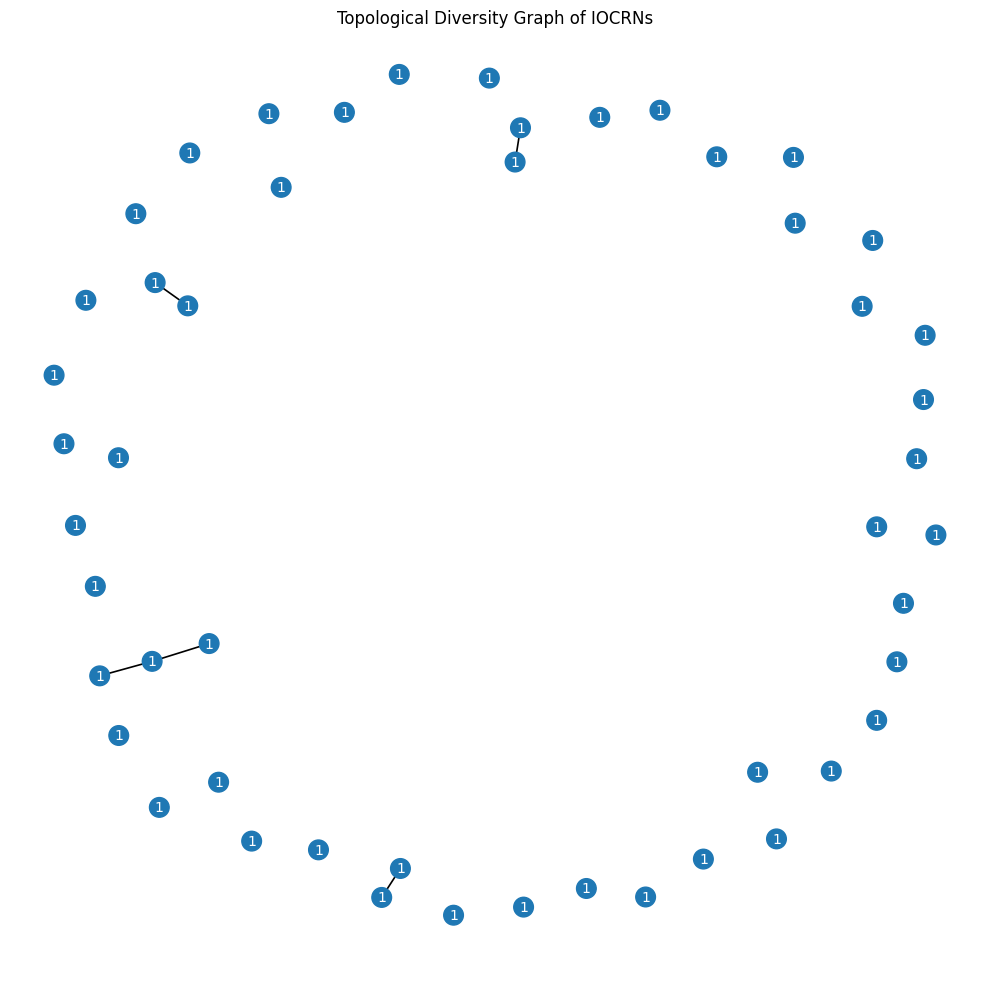

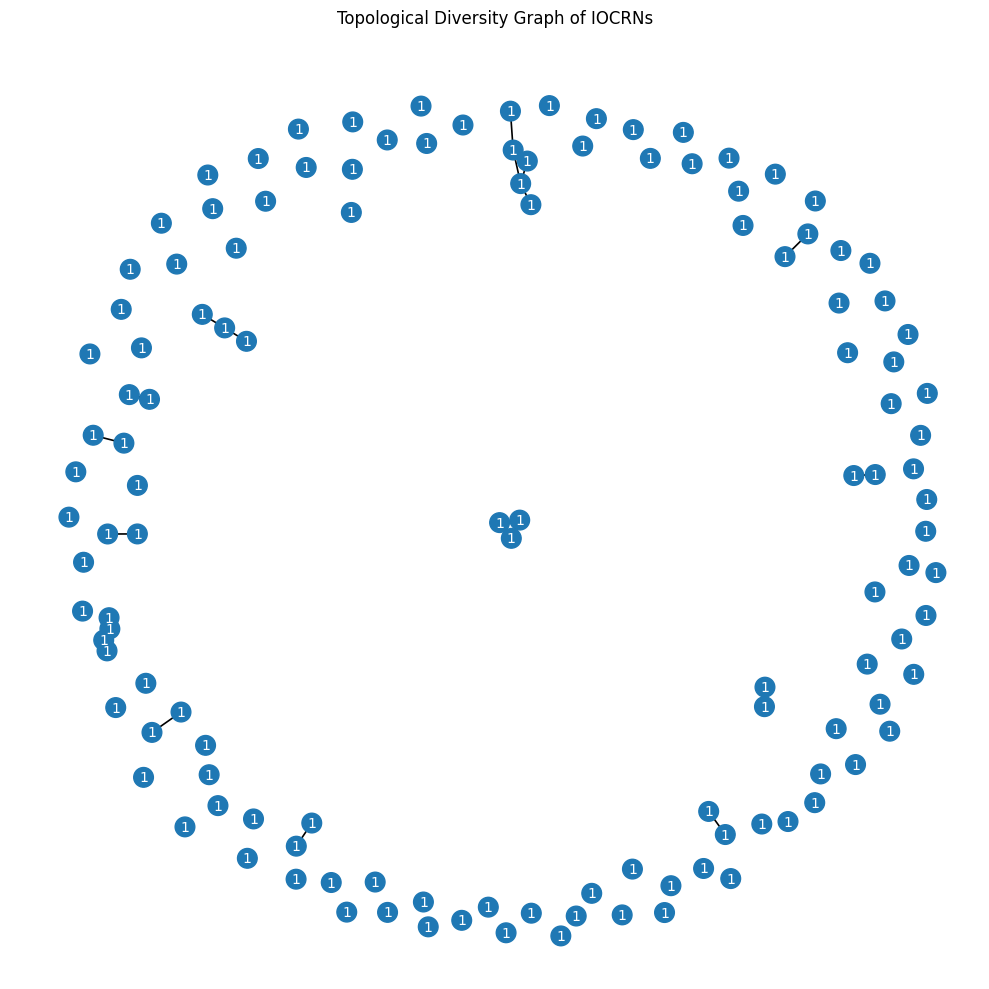

In [12]:
# checkpoint_path = "habituation_task_chkpt.pkl"
checkpoint_path = "sensitization_task_chkpt.pkl"
trainer.run(epochs=cfg.train.epochs, checkpoint_path=checkpoint_path)

## 9) Inspect the best CRN

The trainer keeps a **Hall of Fame** of good CRNs found during rollouts.


In [13]:
trainer.inspect_best(plot=True)

best = trainer.best_crn()
print("Hall of Fame size:", len(trainer.s.mult_env.hall_of_fame))
if best is not None:
    print("Best loss:", best.last_task_info.get("reward", None))


Best CRN loss: -0.03666349578027924
Inputs: ['u_1'] 
Species: ['X_1', 'X_2', 'X_3'] 
Output Species: ['X_3'] 
∅ ----> X_1;  [MAK(1.0, u_1)]
∅ ----> X_2;  [MAK(0.1)]
X_1 ----> ∅;  [MAK(0.1)]
X_1 ----> X_2 + X_2;  [MAK(0.29432159662246704)]
X_1 ----> X_2 + X_3;  [MAK(0.22057916224002838)]
X_2 ----> ∅;  [MAK(0.1)]
X_3 ----> ∅;  [MAK(0.1)]
X_3 ----> X_2;  [MAK(0.45379573106765747)]
X_2 + X_2 ----> X_1;  [MAK(0.14210563898086548)]
X_2 + X_3 ----> X_1 + X_2;  [MAK(0.5341036915779114)]
Hall of Fame size: 50
Best loss: -0.03666349578027924


In [14]:
index = 1
trainer.inspect_hof(index).plot_transient_response_piecewise(gap=True)

HoF[1] loss: -0.03183153232870003
Inputs: ['u_1'] 
Species: ['X_1', 'X_2', 'X_3'] 
Output Species: ['X_3'] 
∅ ----> X_1;  [MAK(1.0, u_1)]
∅ ----> X_2;  [MAK(0.1)]
X_1 ----> ∅;  [MAK(0.1)]
X_2 ----> ∅;  [MAK(0.1)]
X_2 ----> X_3;  [MAK(0.22435350716114044)]
X_3 ----> ∅;  [MAK(0.1)]
X_1 + X_1 ----> X_1;  [MAK(0.847420871257782)]
X_1 + X_3 ----> X_3 + X_3;  [MAK(0.6389644145965576)]
X_2 + X_2 ----> ∅;  [MAK(1.434248685836792)]
X_2 + X_2 ----> X_1 + X_2;  [MAK(0.5071649551391602)]


(<Figure size 960x660 with 6 Axes>,
 [<Axes: title={'center': 't_on=1, t_off=4 (T=5) | X_3'}, ylabel='Δy'>,
  <Axes: title={'center': 't_on=1, t_off=9 (T=10) | X_3'}, ylabel='Δy'>,
  <Axes: title={'center': 't_on=1, t_off=14 (T=15) | X_3'}, xlabel='Time', ylabel='Δy'>])

## 10) Sample and re-simulate

After training, we can **draw new CRN designs from the learned policy** (sampling runs in evaluation mode, i.e., no gradient updates) and **re-evaluate** them.

This is useful for:
- **Model exploration:** quickly inspect diverse candidates generated by the policy.
- **Controlled re-simulation:** re-run sampled CRNs under modified conditions (`u_list/u_spec`, `ic`, etc.).

Sampling produces a dedicated **sample Hall-of-Fame** that stores the best `K` sampled environments (lowest loss) for later inspection and checkpointing.


In [15]:
trainer.sample(10, 10, ic=("constant", 1.0))


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails to satisfy constraints.


[cvInitialSetup, Error: -22] y0 fails t

We can now inspect newly sampled I/O CRNs.

Inputs: ['u_1'] 
Species: ['X_1', 'X_2', 'X_3'] 
Output Species: ['X_3'] 
∅ ----> X_1;  [MAK(1.0, u_1)]
∅ ----> X_2;  [MAK(0.1)]
X_1 ----> ∅;  [MAK(0.1)]
X_1 ----> X_3;  [MAK(1.0547057390213013)]
X_2 ----> ∅;  [MAK(0.1)]
X_3 ----> ∅;  [MAK(0.1)]
X_1 + X_1 ----> X_1 + X_3;  [MAK(0.43763434886932373)]
X_1 + X_2 ----> ∅;  [MAK(0.5011275410652161)]
X_2 + X_3 ----> X_1 + X_2;  [MAK(0.41673383116722107)]
X_3 + X_3 ----> X_1 + X_3;  [MAK(0.9455429911613464)]
reward: -0.015732184165229177


/local0/rossin/git/GenAI-Net/.venv/lib/python3.10/site-packages/RL4CRN/utils/plotting_style.py:120: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(**cfg.get("legend_kwargs", {}))


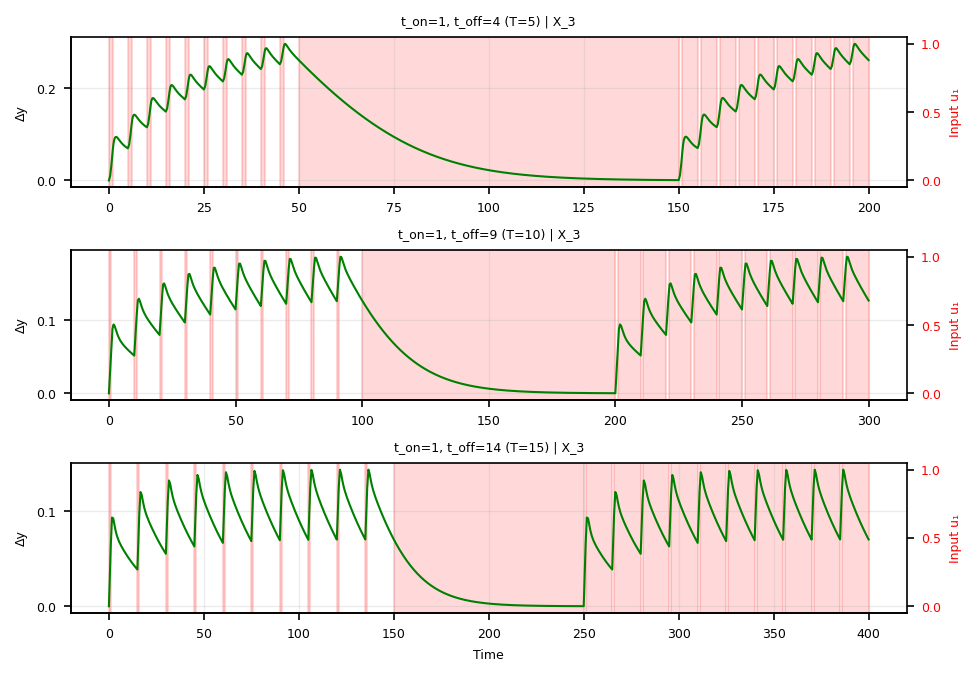

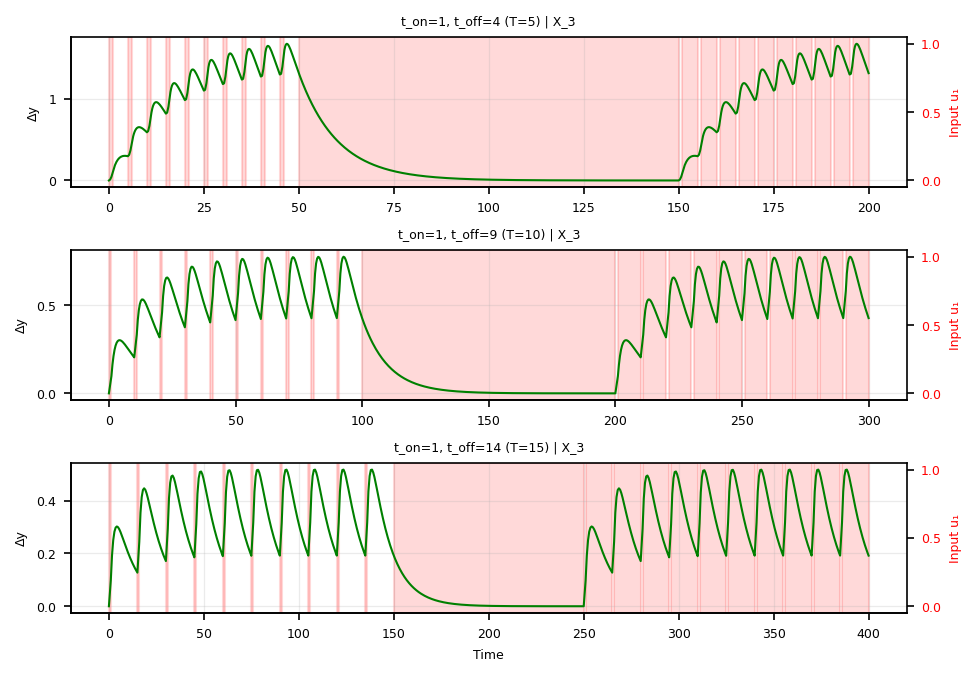

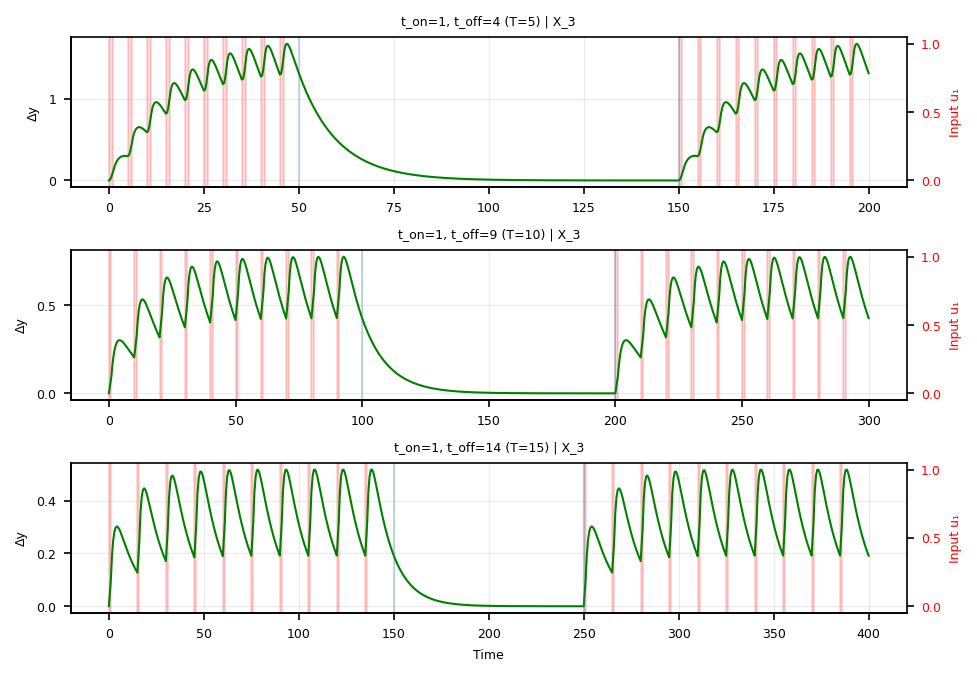

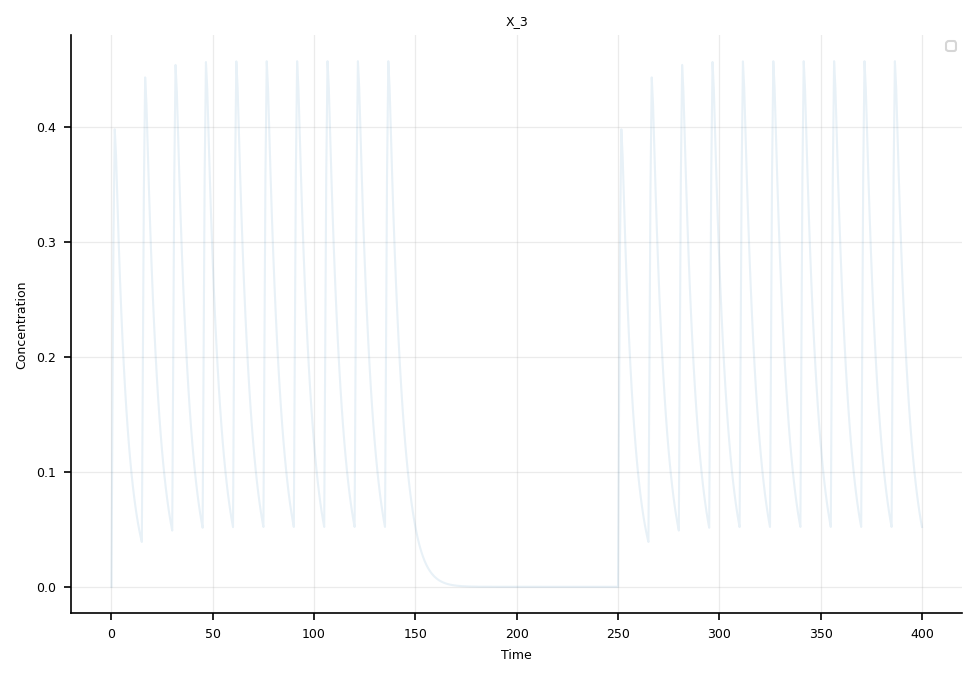

In [16]:
import matplotlib.pyplot as plt

index = 0
crn_s = trainer.get_sampled_crns()[index]
print(crn_s)
print("reward:", crn_s.last_task_info.get("reward", None))

# Plotters depend on your IOCRN implementation
crn_s.plot_transient_response(); plt.show()


Save again our results.

In [17]:
trainer.save(checkpoint_path)

Saved checkpoint: sensitization_task_chkpt.pkl


## 11) Loading a saved Session/Trainer from a checkpoint

`load_session_and_trainer` reconstructs wiring and restores weights, history, HoFs, and RNG states.


In [18]:
from RL4CRN.utils.input_interface import load_session_and_trainer

trainer_loaded = load_session_and_trainer(checkpoint_path, device="cuda")
trainer_loaded.inspect_best()

Best CRN loss: -0.03666349578027924
Inputs: ['u_1'] 
Species: ['X_1', 'X_2', 'X_3'] 
Output Species: ['X_3'] 
∅ ----> X_1;  [MAK(1.0, u_1)]
∅ ----> X_2;  [MAK(0.1)]
X_1 ----> ∅;  [MAK(0.1)]
X_1 ----> X_2 + X_2;  [MAK(0.29432159662246704)]
X_1 ----> X_2 + X_3;  [MAK(0.22057916224002838)]
X_2 ----> ∅;  [MAK(0.1)]
X_3 ----> ∅;  [MAK(0.1)]
X_3 ----> X_2;  [MAK(0.45379573106765747)]
X_2 + X_2 ----> X_1;  [MAK(0.14210563898086548)]
X_2 + X_3 ----> X_1 + X_2;  [MAK(0.5341036915779114)]


## 12) Re-simulate Hall-of-Fame CRNs under new conditions

We can take the training Hall-of-Fame CRNs and re-simulate them under a new IC and/or new input set.

This uses `Trainer.resimulate(...)` which clones CRNs before evaluation (so old results remain intact).


In [19]:
hof_crns = [item.state for item in trainer.s.mult_env.hall_of_fame]

trainer.s.crn_template

crns_new = trainer.resimulate(
    hof_crns,
)

trainer.inspect(crns_new[0])


CRN loss: -0.03666349578027924
Inputs: ['u_1'] 
Species: ['X_1', 'X_2', 'X_3'] 
Output Species: ['X_3'] 
∅ ----> X_1;  [MAK(1.0, u_1)]
∅ ----> X_2;  [MAK(0.1)]
X_1 ----> ∅;  [MAK(0.1)]
X_1 ----> X_2 + X_2;  [MAK(0.29432159662246704)]
X_1 ----> X_2 + X_3;  [MAK(0.22057916224002838)]
X_2 ----> ∅;  [MAK(0.1)]
X_3 ----> ∅;  [MAK(0.1)]
X_3 ----> X_2;  [MAK(0.45379573106765747)]
X_2 + X_2 ----> X_1;  [MAK(0.14210563898086548)]
X_2 + X_3 ----> X_1 + X_2;  [MAK(0.5341036915779114)]
